<a href="https://colab.research.google.com/github/Malbasahi/TechnoHacks_Heart_Disease_Prediction/blob/main/Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [7]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Life Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sandhu, K

In [8]:
print(heart_disease.data)

{'ids': None, 'features':      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3

In [9]:
# Manually define feature names based on available information
feature_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

In [10]:
# Create DataFrames for features and target
X_df = pd.DataFrame(X, columns=feature_names)
y_df = pd.DataFrame(y, columns=['num'])

In [11]:
# Data preprocessing - Impute missing values with median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

<Axes: >

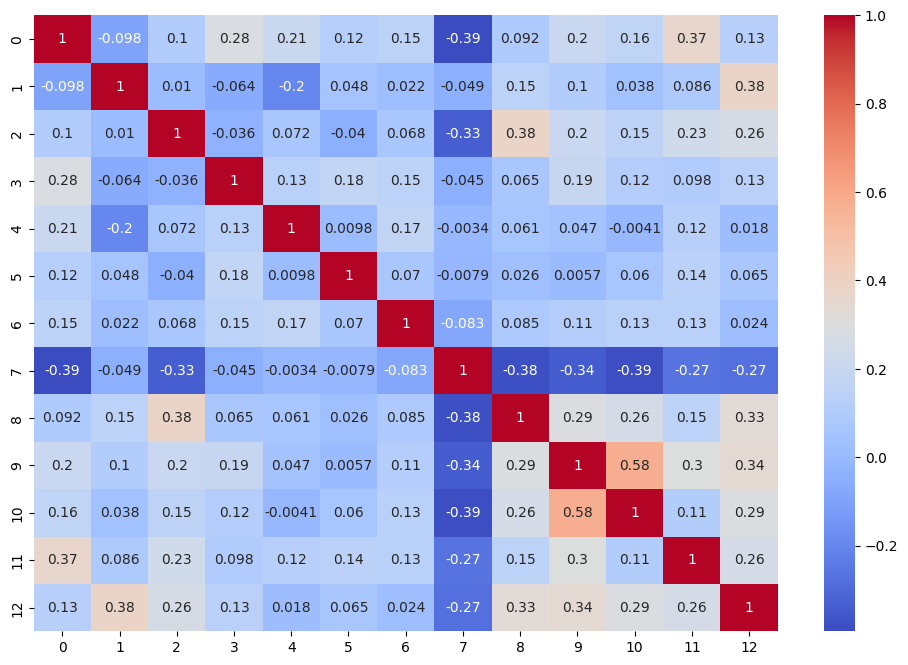

In [12]:
# EDA and feature selection with visualizations
plt.figure(figsize=(12, 8))
# Correlation matrix heatmap
corr_matrix = np.corrcoef(X, rowvar=False)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [13]:
# Select the most relevant features using chi-squared test
# You can change the value of k (number of features to select)
k = 5
X_new = SelectKBest(chi2, k=k).fit_transform(X, y)
print(X_new)

[[150.    0.    2.3   0.    6. ]
 [108.    1.    1.5   3.    3. ]
 [129.    1.    2.6   2.    7. ]
 ...
 [115.    1.    1.2   1.    7. ]
 [174.    0.    0.    1.    3. ]
 [173.    0.    0.    0.    3. ]]


In [14]:
# Manually define feature names based on selected features
selected_feature_names = ['thalach', 'exang', 'oldpeak', 'ca', 'thal']

In [15]:
# Create DataFrames for features and target
X_df = pd.DataFrame(X, columns=feature_names)
y_df = pd.DataFrame(y, columns=['num'])

In [16]:
# Data preprocessing
# Replace missing values with appropriate values (e.g., median)
X_new[np.isnan(X_new)] = np.nanmedian(X_new)
X_new = np.nan_to_num(X_new)

<Axes: >

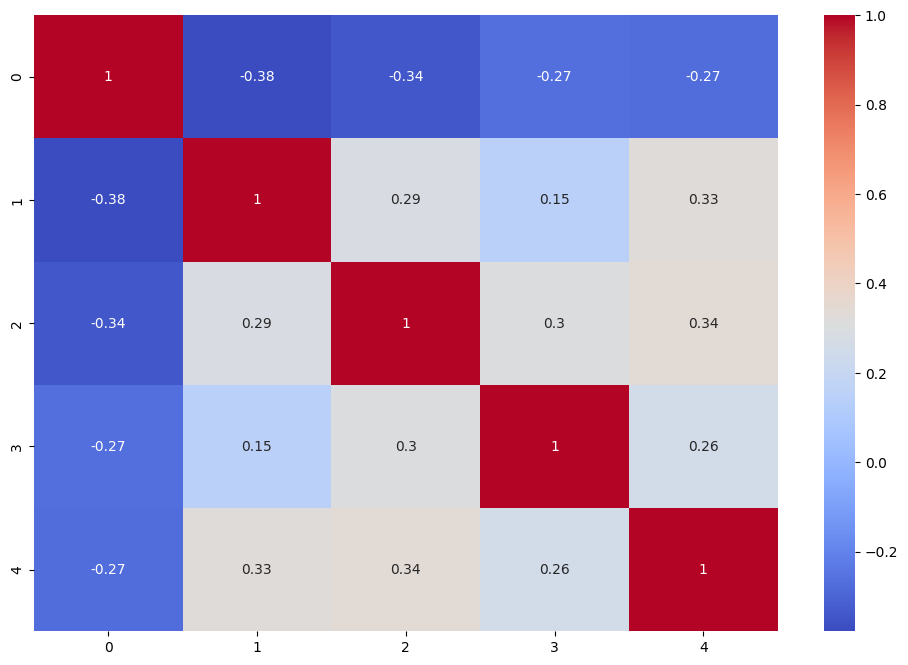

In [17]:
# EDA and feature selection with visualizations
plt.figure(figsize=(12, 8))
# Correlation matrix heatmap
corr_matrix = np.corrcoef(X_new, rowvar=False)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [19]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
smote = SMOTE(random_state=42, sampling_strategy='auto')  # Adjust sampling_strategy if needed
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [42]:
from sklearn.impute import SimpleImputer

# Impute missing values in X_test_scaled
imputer = SimpleImputer(strategy='mean')
X_test_scaled_imputed = imputer.fit_transform(X_test_scaled)

In [43]:
# Remove rows with missing values from X_test_scaled and y_test
mask = ~np.isnan(X_test_scaled).any(axis=1)
X_test_scaled = X_test_scaled[mask]
y_test = y_test[mask]

In [39]:
# Initialize additional models
base_models = {
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "XGBoost": XGBClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),  # SVC without OneVsRestClassifier
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Multilayer Perceptron": MLPClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

# Hyperparameter tuning for each model
best_models = {}
for model_name, model in base_models.items():
    param_grid = {}  # Define hyperparameter grid for each model
    if model_name == "Support Vector Machine":
        param_grid = {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "poly", "rbf"],
        }
    elif model_name == "k-Nearest Neighbors":
        param_grid = {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
        }
    # Add more hyperparameter grids for other models as needed

    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,  # Use all CPU cores
    )
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best model from grid search
    best_models[model_name] = grid_search.best_estimator_

# Wrap the best models with OneVsRestClassifier
for model_name in best_models.keys():
    if model_name != "Support Vector Machine":  # Skip SVC, which is already a OneVsRestClassifier
        best_models[model_name] = OneVsRestClassifier(best_models[model_name])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

In [44]:
# Fit the best models with the training data
for model_name, model in best_models.items():
    if model_name == "XGBoost":
        model.set_params(estimator__num_class=2)  # Set num_class for XGBoost
    model.fit(X_train_resampled, y_train_resampled)

# Evaluate and compare all models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\nTraining and evaluating {model_name}...")

    # Compute ROC AUC scores and classification report
    y_prob = model.predict_proba(X_test_scaled)
    for i in range(n_classes):
        roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train))[:, i], y_prob[:, i])
        print(f"{model_name} - Class {i} (ROC AUC): {roc_auc:.2f}")

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ne


Training and evaluating Random Forest...
Random Forest - Class 0 (ROC AUC): 0.94
Random Forest - Class 1 (ROC AUC): 0.45
Random Forest - Class 2 (ROC AUC): 0.75
Random Forest - Class 3 (ROC AUC): 0.74
Random Forest - Class 4 (ROC AUC): 0.79

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        29
           1       0.14      0.08      0.11        12
           2       0.27      0.33      0.30         9
           3       0.29      0.29      0.29         7
           4       0.00      0.00      0.00         4

    accuracy                           0.54        61
   macro avg       0.29      0.33      0.31        61
weighted avg       0.47      0.54      0.50        61


Training and evaluating XGBoost...
XGBoost - Class 0 (ROC AUC): 0.89
XGBoost - Class 1 (ROC AUC): 0.37
XGBoost - Class 2 (ROC AUC): 0.80
XGBoost - Class 3 (ROC AUC): 0.71
XGBoost - Class 4 (ROC AUC): 0.71

Classification Repor

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


ValueError: ignored